In [97]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

Text(0.5, 1.0, 'Segmentation')

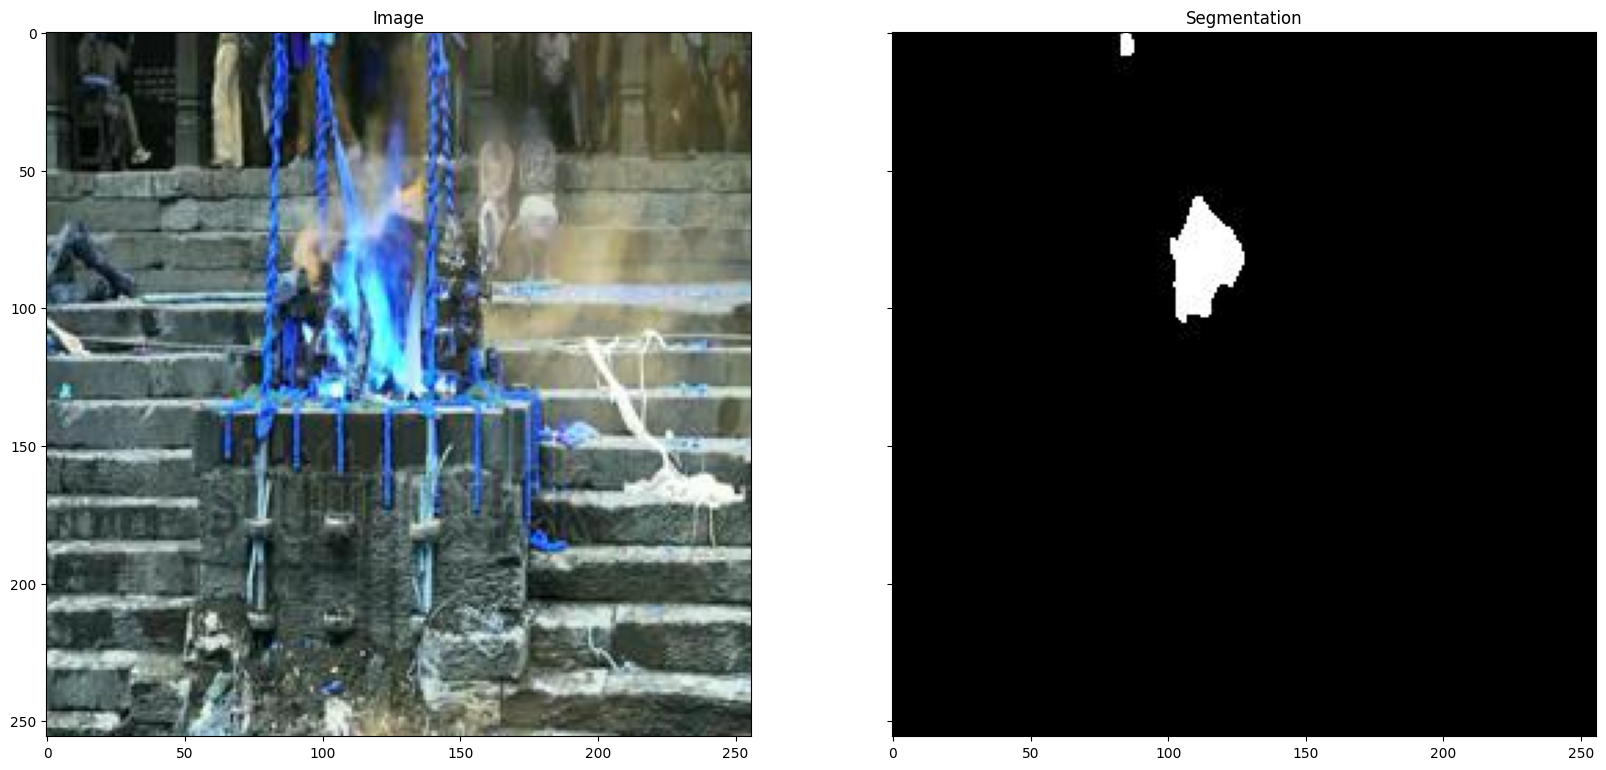

In [98]:
ROOT_DIR = "/kaggle/input/fire-segmentation-image-dataset"
image_1 = cv2.imread(os.path.join(ROOT_DIR, "Image", "Fire", "Img_10.jpg"))
mask_1 = cv2.imread(os.path.join(ROOT_DIR, "Segmentation_Mask", "Fire", "Img_10.jpg"))

fig, arr = plt.subplots(1, 2, sharey=True, figsize=(20, 10))
arr[0].imshow(image_1)
arr[0].set_title('Image')
arr[1].imshow(mask_1)
arr[1].set_title('Segmentation')

In [99]:
def load_x():
    images = [os.path.join(ROOT_DIR, "Image", "Fire", x) for x in os.listdir(os.path.join(ROOT_DIR, "Image", "Fire"))]
    masks = [os.path.join(ROOT_DIR, "Segmentation_Mask", "Fire", x) for x in os.listdir(os.path.join(ROOT_DIR, "Segmentation_Mask", "Fire"))]

    image_filenames = tf.constant(images)
    mask_filenames = tf.constant(masks)
    
    return tf.data.Dataset.from_tensor_slices((image_filenames, mask_filenames))

def get_img(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess_img(img, mask):
    p_img = tf.image.resize(img, (96, 128), method="nearest")
    p_mask = tf.image.resize(mask, (96, 128), method="nearest")
    p_img = p_img/255.
    p_mask = tf.cast(p_mask > 0, dtype=tf.uint8)
    return p_img, p_mask

dataset_filename = load_x()
image_df = dataset_filename.map(get_img)
processed_image_df = image_df.map(preprocess_img)

In [100]:
import tensorflow.keras.layers as tfl

def conv_block(inputs=None, n_filters=32, max_pool=True, dropout_prob=0):
    x = tfl.Conv2D(n_filters, 3, kernel_initializer="he_normal", padding="same", activation="relu")(inputs)
    x = tfl.Conv2D(n_filters, 3, kernel_initializer="he_normal", padding="same", activation="relu")(x)
    
    if dropout_prob > 0:
        x = tfl.Dropout(dropout_prob)(x)
    if max_pool:
        next_layer = tfl.MaxPooling2D(2, strides=2)(x)
    else:
        next_layer = x

    return next_layer, x

In [101]:
def upsampling_block(inputs=None, res_inp=None, n_filters=32):
    
    x = tfl.Conv2DTranspose(n_filters, 3, strides=2, padding="same")(inputs)
    x = tfl.concatenate([x, res_inp], axis=3)
    x = tfl.Conv2D(n_filters, 3, kernel_initializer="he_normal", padding="same", activation="relu")(x)
    x = tfl.Conv2D(n_filters, 3, kernel_initializer="he_normal", padding="same", activation="relu")(x)
    
    return x


In [102]:
def simple_model(input_shape, n_filters=32, classes=2 ):
    
    
    inputs = tf.keras.Input(shape=input_shape)
    x, res_1 = conv_block(inputs=inputs, n_filters=n_filters)
    x, res_2 = conv_block(inputs=x, n_filters=n_filters*2)
    x, res_3 = conv_block(inputs=x, n_filters=n_filters*4)
    x, res_4 = conv_block(inputs=x, n_filters=n_filters*8, dropout_prob=0.3)
    x, res_5 = conv_block(inputs=x, n_filters=n_filters*16, dropout_prob=0.3, max_pool=False)
#     x = tfl.Conv2D(n_filters*16, 3, padding="same", kernel_initializer="he_normal", activation="relu")(x)
    
    x = upsampling_block(inputs=x, res_inp=res_4, n_filters=n_filters*8)
    x = upsampling_block(inputs=x, res_inp=res_3, n_filters=n_filters*4)
    x = upsampling_block(inputs=x, res_inp=res_2, n_filters=n_filters*2)
    x = upsampling_block(inputs=x, res_inp=res_1, n_filters=n_filters)
    
    x = tfl.Conv2D(n_filters, 3, activation="relu", padding="same", kernel_initializer="he_normal")(x)
    x = tfl.Conv2D(1, 1, padding="same")(x)
    
    model = tf.keras.Model(inputs, x)
    return model

In [103]:
model_alpha = simple_model((96, 128, 3))
model_alpha.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_418 (Conv2D)            (None, 96, 128, 32)  896         ['input_33[0][0]']               
                                                                                                  
 conv2d_419 (Conv2D)            (None, 96, 128, 32)  9248        ['conv2d_418[0][0]']             
                                                                                                  
 max_pooling2d_117 (MaxPooling2  (None, 48, 64, 32)  0           ['conv2d_419[0][0]']       

In [108]:
model_alpha.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])

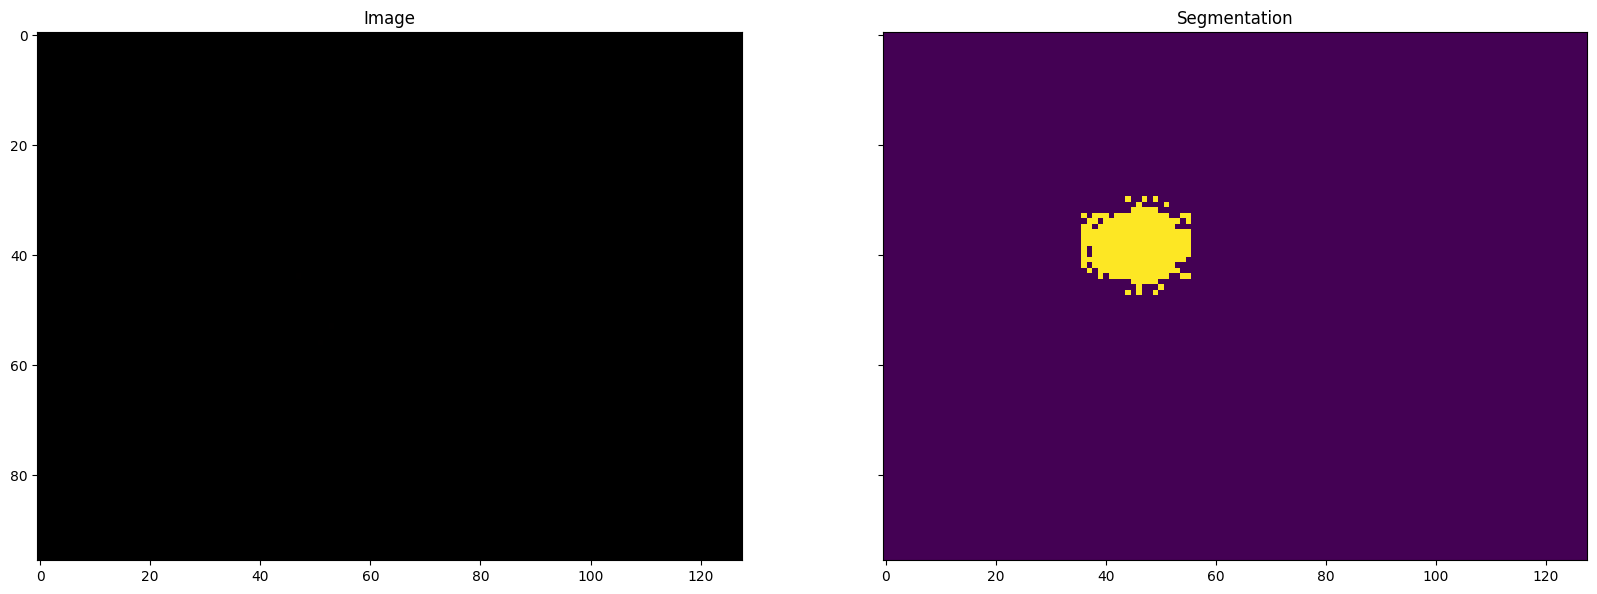

In [105]:
def display(image_mask):
    image_1, mask_1 = image_mask

    fig, arr = plt.subplots(1, 2, sharey=True, figsize=(20, 10))
    arr[0].imshow(image_1)
    arr[0].set_title('Image')
    arr[1].imshow(mask_1)
    arr[1].set_title('Segmentation')


for image, mask in processed_image_df.take(1):
    display([image, mask])
    

In [ ]:
EPOCHS=40
buffer=500
batch_size=tf.constant(64, dtype=tf.int64)
processed_image_df.batch(batch_size)
train_dataset = processed_image_df.cache().shuffle(buffer).batch(batch_size)
print(processed_image_df.element_spec)

history = model_alpha.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
  4/430 [..............................] - ETA: 1:45:31 - loss: 1.9291 - accuracy: 0.9740